### Part 2: PCA Method with Maximum Likelihood Estimation 

- mean-centering items

In [ ]:
import time
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

In [ ]:
# In Jupyter: this is the folder where the notebook lives (SECTION1_DimensionalityReduction/code)
nb_dir = Path.cwd()

# Project root: SECTION1_DimensionalityReduction
project_dir = nb_dir.parent

# Input paths
ratings_path = project_dir / "data" / "ratings.csv"
item_avg_path = project_dir / "results" / "tables" / "stats_analysis" / "item_avg_ratings.csv"
section_results_path = project_dir / "results" / "tables" / "Part_2"
# Load
ratings_df = pd.read_csv(ratings_path)
item_avg_df = pd.read_csv(item_avg_path)

# Merge + mean-center
merged_df = ratings_df.merge(item_avg_df, on="movieId", how="left")
merged_df["mean_centered_rating"] = merged_df["rating"] - merged_df["avg_rating"]

# Output (same folder as item_avg_ratings.csv)
output_df = merged_df[["userId", "movieId", "mean_centered_rating", "timestamp"]].copy()
output_path = section_results_path / "item_mean_centered.csv"

output_df.to_csv(output_path, index=False)

print(f"Mean-centered ratings saved to: {output_path}")
print(f"Total rows processed: {len(output_df)}")
print(output_df.head(10))


Mean-centered ratings saved to: c:\Users\sama\OneDrive\Desktop\project\github submission\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\part_2\item_mean_centered.csv
Total rows processed: 109342
   userId  movieId  mean_centered_rating  timestamp
0      24      367              0.721111  994232987
1      24      372             -1.106667  995097444
2      24      593             -0.158889  994071088
3      24      802             -0.447778  995096937
4      24      832             -0.427778  994232682
5      24     1129             -0.347778  993972188
6      24     1197             -0.168889  993971477
7      24     1213              0.740000  994071115
8      24     1784              0.191111  994232569
9      24     2011              0.501111  993972573


- form products of deviations

In [ ]:
# Notebook folder: SECTION1_DimensionalityReduction/code
nb_dir = Path.cwd()

# Project root: SECTION1_DimensionalityReduction
project_dir = nb_dir.parent

# Correct local path
mean_centered_path = project_dir / "results" / "tables" / "Part_2" / "item_mean_centered.csv"

df = pd.read_csv(mean_centered_path)
print("Loaded:", mean_centered_path)
print(df.head())


Loaded: c:\Users\sama\OneDrive\Desktop\project\github submission\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\Part_2\item_mean_centered.csv
   userId  movieId  mean_centered_rating  timestamp
0      24      367              0.721111  994232987
1      24      372             -1.106667  995097444
2      24      593             -0.158889  994071088
3      24      802             -0.447778  995096937
4      24      832             -0.427778  994232682


In [ ]:
# df already loaded from item_mean_centered.csv
user_groups = df.groupby("userId")

rows = []
for _, g in user_groups:
    items = g[["movieId", "mean_centered_rating"]].to_numpy()
    for (i, r_i), (j, r_j) in combinations(items, 2):
        if i < j:   # keep upper triangle only
            rows.append((int(i), int(j), float(r_i * r_j)))
        else:
            rows.append((int(j), int(i), float(r_i * r_j)))

prod_df = pd.DataFrame(rows, columns=["item_i", "item_j", "product"])

co_cov_df = (prod_df
    .groupby(["item_i", "item_j"])
    .agg(sum_product=("product", "sum"),
         count=("product", "count"))
    .reset_index()
)

# Save in the SAME folder as item_avg_ratings.csv
out_path = mean_centered_path.parent / "item_item_cov_components.csv"
co_cov_df.to_csv(out_path, index=False)

print("Saved:", out_path)
print(co_cov_df.head())

co_cov_df.head()

Saved: c:\Users\sama\OneDrive\Desktop\project\github submission\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\Part_2\item_item_cov_components.csv
   item_i  item_j  sum_product  count
0       9      13    10.857775     22
1       9      20    45.821462    152
2       9      51     0.000035      3
3       9      55    -2.284002     18
4       9     100    26.584767    129


,item_i,item_j,sum_product,count
0,9,13,10.857775,22
1,9,20,45.821462,152
2,9,51,0.000035,3
3,9,55,-2.284002,18
4,9,100,26.584767,129


In [ ]:
co_cov_df.tail()

,item_i,item_j,sum_product,count
137700,126783,129931,0.000002,1
137701,128594,128624,0.000000,1
137702,129354,129769,-0.001956,1
137703,129354,130490,0.392089,1
137704,130490,130500,0.000000,1


1- calculate covariance matrix

In [ ]:
# Paths
nb_dir = Path.cwd()                 # .../SECTION1_DimensionalityReduction/code
project_dir = nb_dir.parent         # .../SECTION1_DimensionalityReduction
stats_dir = project_dir / "results" / "tables" / "Part_2"

pairs_path = stats_dir / "item_item_cov_components.csv"
mc_path = stats_dir / "item_mean_centered.csv"

pairs_df = pd.read_csv(pairs_path)
mc_df = pd.read_csv(mc_path)

# -------------------------
# A) Build item index (manual)
# -------------------------
items_set = set()
for row in mc_df.itertuples(index=False):
    items_set.add(int(row.movieId))

items = sorted(items_set)
N = len(items)

item_to_idx = {}
idx_to_item = {}
for idx, item in enumerate(items):
    item_to_idx[item] = idx
    idx_to_item[idx] = item

# Initialize covariance matrix with zeros (pure Python list of lists)
cov = []
for _ in range(N):
    cov.append([0.0] * N)

# -------------------------
# B) Off-diagonal cov(i,j) = sum_product / (count - 1)  (sample covariance)
# -------------------------
for row in pairs_df.itertuples(index=False):
    i_item = int(row.item_i)
    j_item = int(row.item_j)
    sum_prod = float(row.sum_product)
    n_ij = int(row.count)

    if n_ij >= 2:
        cov_ij = sum_prod / (n_ij - 1)   # <-- sample covariance
        i = item_to_idx[i_item]
        j = item_to_idx[j_item]
        cov[i][j] = cov_ij
        cov[j][i] = cov_ij  # symmetry

# -------------------------
# C) Diagonal variances var(i) = sum(r'^2) / (n_i - 1)
# -------------------------
# We'll compute sum_sq and n_i manually using dicts
sum_sq = {}
count_i = {}

for row in mc_df.itertuples(index=False):
    m = int(row.movieId)
    r = float(row.mean_centered_rating)
    sq = r * r

    if m not in sum_sq:
        sum_sq[m] = 0.0
        count_i[m] = 0

    sum_sq[m] += sq
    count_i[m] += 1

for m in items:
    n_i = count_i.get(m, 0)
    if n_i >= 2:
        var = sum_sq[m] / (n_i - 1)
        i = item_to_idx[m]
        cov[i][i] = var

print("Cov matrix built.")
print("N items:", N)



Cov matrix built.
N items: 900


In [ ]:
# Sanity checks
# 1) symmetry check on a few random positions
print("cov[0][1] vs cov[1][0]:", cov[0][1], cov[1][0])

# 2) diagonal should be >= 0 (variance) for most items
neg_diag = 0
for i in range(N):
    if cov[i][i] < 0:
        neg_diag += 1
print("Negative diagonal count:", neg_diag)


bad = 0
for i in range(N):
    for j in range(N):
        v = cov[i][j]
        if v != v or v == float("inf") or v == float("-inf"):  # NaN or inf
            bad += 1
print("NaN/Inf count:", bad)


cov[0][1] vs cov[1][0]: 0.5170369194591418 0.5170369194591418
Negative diagonal count: 0
NaN/Inf count: 0


In [ ]:
cov_path = stats_dir / "cov_matrix_sample_900.csv"

with open(cov_path, "w", encoding="utf-8") as f:
    f.write("movieId," + ",".join(str(x) for x in items) + "\n")
    for i, item in enumerate(items):
        f.write(str(item) + "," + ",".join(str(v) for v in cov[i]) + "\n")

print("Saved:", cov_path)


Saved: c:\Users\sama\OneDrive\Desktop\project\github submission\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\Part_2\cov_matrix_sample_900.csv


2- Determine top5 principal components and top 10 principal components
- apply PCA

In [ ]:
# 1) Your covariance matrix Σ (900x900) already computed manually as cov (list of lists)
Sigma = np.array(cov, dtype=float)

# 2) Eigen-decomposition of Σ (PCA on covariance)
# Sigma is symmetric => eigh is the correct stable method
eigvals, eigvecs = np.linalg.eigh(Sigma)

# 3) Sort eigenvalues/eigenvectors in descending order
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]


# 4) Select Top 5 Peers (Components)
# We take the first 5 columns from the sorted eigenvectors
top_5_vals = eigvals[:5]
top_5_vecs = eigvecs[:, :5]

# 5) Select Top 10 Peers (Components)
top_10_vals = eigvals[:10]
top_10_vecs = eigvecs[:, :10]

# --- Display Results ---
print(f"\n[Top 5 Eigenvalues (Variance)]:")
print(top_5_vals)

print(f"\n[Top 5 Eigenvectors Matrix Shape]: {top_5_vecs.shape}")





[Top 5 Eigenvalues (Variance)]:
[93.90189866 56.63497699 46.82294351 42.83080171 39.47656263]

[Top 5 Eigenvectors Matrix Shape]: (900, 5)


3- Determine reduced dimensional space for each user in case of using top 5-peers

In [ ]:
# Paths (notebook in SECTION1_DimensionalityReduction/code)
nb_dir = Path.cwd()
project_dir = nb_dir.parent
stats_dir = project_dir / "results" / "tables" / "Part_2"

# Load mean-centered ratings (long format)
mc = pd.read_csv(stats_dir / "item_mean_centered.csv")

# Load / reuse top-5 principal components
# eigvecs_sorted must already exist in your notebook
P5 = top_5_vecs   # shape: (num_items, 5)

# Build item index (same order used in PCA!)
items = sorted(mc["movieId"].unique())
item_to_idx = {item: idx for idx, item in enumerate(items)}

# Prepare container for user projections
user_vectors = {}

# Project each user
for user_id, group in mc.groupby("userId"):
    z_u = np.zeros(5)

    for _, row in group.iterrows():
        item = row["movieId"]
        r_ui = row["mean_centered_rating"]

        i = item_to_idx[item]
        z_u += r_ui * P5[i]

    user_vectors[user_id] = z_u

# Convert to DataFrame
user_emb_df = pd.DataFrame.from_dict(
    user_vectors, orient="index",
    columns=[f"PC{i}" for i in range(1, 6)]
)
user_emb_df.index.name = "userId"

# Save
out_path = stats_dir / "user_embeddings_pca5.csv"
user_emb_df.reset_index().to_csv(out_path, index=False)

print("Saved user embeddings to:", out_path)
user_emb_df.head()


Saved user embeddings to: c:\Users\sama\OneDrive\Desktop\project\github submission\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\part_2\user_embeddings_pca5.csv


,PC1,PC2,PC3,PC4,PC5
userId,,,,,
24,0.198755,0.135511,-0.045010,-0.329294,-0.297288
34,0.051505,-0.101357,-0.008440,0.046999,0.017696
36,-0.015507,-0.003016,0.007882,0.012687,0.016302
87,0.013992,-0.009725,-0.001627,0.024941,-0.006267
88,-0.274503,0.247012,-0.133253,-0.521716,-0.378698


4- Use the results from point 3 compute the rating predictions of the original missing rating for each of the target items (I1 and l2) using the top 5-peers.

In [ ]:
# ---------------- Paths ----------------
nb_dir = Path.cwd()
project_dir = nb_dir.parent
stats_dir = project_dir / "results" / "tables" / "stats_analysis"
data_dir = project_dir / "data"
output_dir = project_dir / "results" / "tables" / "Part_2"

# ---------------- Load raw ratings (to know who REALLY rated the target) ----------------
df = pd.read_csv(data_dir / "ratings.csv")   # columns: userId, movieId, rating, timestamp

# ---------------- Load centered deviations matrix (rating - item mean) ----------------
mc = pd.read_csv(output_dir / "item_mean_centered.csv")  # userId, movieId, mean_centered_rating, timestamp
centered_matrix = mc.pivot(index="userId", columns="movieId", values="mean_centered_rating")

# ---------------- Load item means μ_i ----------------
item_means_df = pd.read_csv(stats_dir / "item_avg_ratings.csv")  # movieId, avg_rating
item_means = item_means_df.set_index("movieId")["avg_rating"].to_dict()

# ---------------- Your reduced user space (MUST already exist) ----------------
# reduced_user_matrix should be a DataFrame indexed by userId with 5 columns (PC1..PC5)
# Example: reduced_user_matrix = user_emb_df.set_index("userId")  # if you saved it that way
# We'll assume you already have it in memory:
# reduced_user_matrix

reduced_user_matrix = user_emb_df.copy()
print("Reduced user matrix shape:", reduced_user_matrix.shape)

# ---------------- Step: cosine similarity between users in reduced space ----------------
user_sim_matrix = cosine_similarity(reduced_user_matrix.values)

user_sim_df = pd.DataFrame(
    user_sim_matrix,
    index=reduced_user_matrix.index,
    columns=reduced_user_matrix.index
)

print("User-user similarity matrix:", user_sim_df.shape)

# ---------------- Prediction function ----------------
def predict_missing_ratings_pca_user_based(target_item_id, k=5):
    """
    Predict missing ratings for target_item_id using k most similar USERS in reduced space.
    Uses deviations (mean-centered ratings) + item mean.
    Only uses peers with positive similarity.
    """
    target_item_id = int(target_item_id)
    print(f"\nProcessing target item: {target_item_id}")

    # A) users who REALLY rated the item (from raw ratings)
    rated_user_ids = df.loc[df["movieId"] == target_item_id, "userId"].unique()
    rated_user_ids = pd.Index(rated_user_ids)

    # keep only rated users who exist in our reduced space
    rated_user_ids = rated_user_ids.intersection(user_sim_df.index)

    # users we want to predict for = all users in reduced space minus those who rated it
    all_users = user_sim_df.index
    missing_user_ids = all_users.difference(rated_user_ids)

    print(f"Users who rated it (in reduced space): {len(rated_user_ids)}")
    print(f"Users to predict (missing): {len(missing_user_ids)}")

    # If we don't know the item mean, can't predict
    if target_item_id not in item_means:
        raise ValueError(f"Item mean not found for movieId={target_item_id}")

    predictions = {}

    for user_u in missing_user_ids:
        # Similarities between user_u and users who rated the item
        sims = user_sim_df.loc[user_u, rated_user_ids]

        # take top-k positive peers
        sims = sims[sims > 0].sort_values(ascending=False).head(k)

        # if no peers, fallback to item mean
        if len(sims) == 0:
            predictions[int(user_u)] = item_means[target_item_id]
            continue

        peer_ids = sims.index
        weights = sims.values

        # deviations of peers for this target item (rating - mean)
        # drop peers who don't have deviation (NaN) for this item (safety)
        peer_devs = centered_matrix.loc[peer_ids, target_item_id].dropna()

        # align weights to remaining peers
        if len(peer_devs) == 0:
            predictions[int(user_u)] = item_means[target_item_id]
            continue

        # re-align sims to the peers that actually have devs
        sims2 = sims.loc[peer_devs.index]
        weights2 = sims2.values

        # weighted average deviation
        pred_dev = (weights2 * peer_devs.values).sum() / weights2.sum()

        # final predicted rating
        predictions[int(user_u)] = item_means[target_item_id] + float(pred_dev)

    return pd.Series(predictions).sort_values(ascending=False)

# ---------------- Execute for your targets ----------------
I1_id = 33930
I2_id = 66549

preds_I1 = predict_missing_ratings_pca_user_based(I1_id, k=5)
print(f"\nTop 10 predicted ratings for I1={I1_id}:")
print(preds_I1.head(10))

preds_I2 = predict_missing_ratings_pca_user_based(I2_id, k=5)
print(f"\nTop 10 predicted ratings for I2={I2_id}:")
print(preds_I2.head(10))

Reduced user matrix shape: (14638, 5)
User-user similarity matrix: (14638, 14638)

Processing target item: 33930
Users who rated it (in reduced space): 5
Users to predict (missing): 14633

Top 10 predicted ratings for I1=33930:
121793    4.111111
101873    4.111111
40007     4.111111
53339     4.111111
102525    4.111111
91934     4.111111
3846      4.111111
83657     4.111111
40375     4.111111
35132     4.111111
dtype: float64

Processing target item: 66549
Users who rated it (in reduced space): 3
Users to predict (missing): 14635

Top 10 predicted ratings for I2=66549:
118930    3.222222
26429     3.222222
26989     3.222222
39950     3.222222
128201    3.222222
57045     3.222222
128239    3.222222
82054     3.222222
57083     3.222222
13102     3.222222
dtype: float64


In [ ]:
# Combine predictions for both targets into one DataFrame
preds_I1_df = preds_I1.reset_index()
preds_I1_df.columns = ["userId", "predicted_rating"]
preds_I1_df["movieId"] = I1_id

preds_I2_df = preds_I2.reset_index()
preds_I2_df.columns = ["userId", "predicted_rating"]
preds_I2_df["movieId"] = I2_id

final_preds = pd.concat([preds_I1_df, preds_I2_df], ignore_index=True)

# Reorder columns
final_preds = final_preds[["userId", "movieId", "predicted_rating"]]

# Save
out_path = output_dir / "predicted_ratings_top5PCs.csv"
final_preds.to_csv(out_path, index=False)

print("Saved predictions to:", out_path)
final_preds.head()


Saved predictions to: c:\Users\sama\OneDrive\Desktop\project\github submission\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\part_2\predicted_ratings_top5PCs.csv


,userId,movieId,predicted_rating
0,121793,33930,4.111111
1,101873,33930,4.111111
2,40007,33930,4.111111
3,53339,33930,4.111111
4,102525,33930,4.111111


- use top 20% neighbors

In [ ]:
preds_I1 = predict_missing_ratings_pca_user_based(I1_id, k=2927)
print(f"\nTop 10 predicted ratings for I1={I1_id}:")
print(preds_I1.head(10))

preds_I2 = predict_missing_ratings_pca_user_based(I2_id, k=2927)
print(f"\nTop 10 predicted ratings for I2={I2_id}:")
print(preds_I2.head(10))


Processing target item: 33930
Users who rated it (in reduced space): 5
Users to predict (missing): 14633

Top 10 predicted ratings for I1=33930:
121793    4.111111
101873    4.111111
40007     4.111111
53339     4.111111
102525    4.111111
91934     4.111111
3846      4.111111
83657     4.111111
40375     4.111111
35132     4.111111
dtype: float64

Processing target item: 66549
Users who rated it (in reduced space): 3
Users to predict (missing): 14635

Top 10 predicted ratings for I2=66549:
118930    3.222222
26429     3.222222
26989     3.222222
39950     3.222222
128201    3.222222
57045     3.222222
128239    3.222222
82054     3.222222
57083     3.222222
13102     3.222222
dtype: float64


In [ ]:
# Combine predictions for both targets into one DataFrame
preds_I1_df = preds_I1.reset_index()
preds_I1_df.columns = ["userId", "predicted_rating"]
preds_I1_df["movieId"] = I1_id

preds_I2_df = preds_I2.reset_index()
preds_I2_df.columns = ["userId", "predicted_rating"]
preds_I2_df["movieId"] = I2_id

final_preds = pd.concat([preds_I1_df, preds_I2_df], ignore_index=True)

# Reorder columns
final_preds = final_preds[["userId", "movieId", "predicted_rating"]]

# Save
out_path = output_dir / "predicted_ratings_top5PCs_top20%K.csv"
final_preds.to_csv(out_path, index=False)

print("Saved predictions to:", out_path)
final_preds.head()


Saved predictions to: c:\Users\Youssef Reda\Desktop\Semester 9\IRS\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\part_2\predicted_ratings_top5PCs_top20%K.csv


,userId,movieId,predicted_rating
0,52506,33930,4.111111
1,22250,33930,4.111111
2,3846,33930,4.111111
3,40375,33930,4.111111
4,79158,33930,4.111111


5- Determine reduced dimensional space for each user in case of using top 10-peers

In [ ]:
print(f"\n[Top 10 Eigenvalues (Variance)]:")
print(top_10_vals)

print(f"\n[Top 10 Eigenvectors Matrix Shape]: {top_10_vecs.shape}")



[Top 10 Eigenvalues (Variance)]:
[93.90189866 56.63497699 46.82294351 42.83080171 39.47656263 35.42523575
 34.26546462 32.69383545 30.77560463 28.31938847]

[Top 10 Eigenvectors Matrix Shape]: (900, 10)


In [ ]:
# Paths (notebook in SECTION1_DimensionalityReduction/code)
nb_dir = Path.cwd()
project_dir = nb_dir.parent
stats_dir = project_dir / "results" / "tables" / "Part_2"

# Load mean-centered ratings (long format)
mc = pd.read_csv(stats_dir / "item_mean_centered.csv")

# Use top-10 principal components
P10 = top_10_vecs   # shape: (num_items, 10)

# Build item index mapping (MUST match PCA item order!)
items = sorted(mc["movieId"].unique())
item_to_idx = {item: idx for idx, item in enumerate(items)}

# Project each user into 10D
user_vectors = {}

for user_id, group in mc.groupby("userId"):
    z_u = np.zeros(10)

    for _, row in group.iterrows():
        item = row["movieId"]
        r_ui = row["mean_centered_rating"]

        i = item_to_idx[item]
        z_u += r_ui * P10[i]

    user_vectors[user_id] = z_u

# Convert to DataFrame
user_emb_df_10 = pd.DataFrame.from_dict(
    user_vectors, orient="index",
    columns=[f"PC{i}" for i in range(1, 11)]
)
user_emb_df_10.index.name = "userId"

# Save
out_path = stats_dir / "user_embeddings_pca10.csv"
user_emb_df_10.reset_index().to_csv(out_path, index=False)

print("Saved user embeddings to:", out_path)
user_emb_df_10.head()


Saved user embeddings to: c:\Users\Youssef Reda\Desktop\Semester 9\IRS\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\part_2\user_embeddings_pca10.csv


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
userId,,,,,,,,,,
24,0.198755,0.135511,-0.045010,-0.329294,-0.297288,0.031252,0.076709,-0.062694,0.375060,-0.121408
34,0.051505,-0.101357,-0.008440,0.046999,0.017696,-0.060563,-0.045021,-0.034494,0.039428,0.053773
36,-0.015507,-0.003016,0.007882,0.012687,0.016302,0.016530,-0.028534,-0.003134,-0.033709,0.013888
87,0.013992,-0.009725,-0.001627,0.024941,-0.006267,-0.029292,-0.029389,-0.018288,0.013788,0.001376
88,-0.274503,0.247012,-0.133253,-0.521716,-0.378698,0.258135,0.424449,0.179723,0.306921,0.114323


6- Use the results from point 5 compute the rating predictions of the original missing rating for each of the target items (I1 and l2) using the top 10-peers.

In [ ]:
# ---------------- Paths ----------------
nb_dir = Path.cwd()
project_dir = nb_dir.parent
stats_dir = project_dir / "results" / "tables" / "stats_analysis"
data_dir = project_dir / "data"
output_dir = project_dir / "results" / "tables" / "Part_2"

# ---------------- Load raw ratings (to know who REALLY rated the target) ----------------
df = pd.read_csv(data_dir / "ratings.csv")   # userId, movieId, rating, timestamp

# ---------------- Load centered deviations matrix (rating - item mean) ----------------
mc = pd.read_csv(output_dir / "item_mean_centered.csv")  # userId, movieId, mean_centered_rating, timestamp
centered_matrix = mc.pivot(index="userId", columns="movieId", values="mean_centered_rating")

# ---------------- Load item means μ_i ----------------
item_means_df = pd.read_csv(stats_dir / "item_avg_ratings.csv")  # movieId, avg_rating
item_means = item_means_df.set_index("movieId")["avg_rating"].to_dict()

# ---------------- Load reduced user space (TOP-10 PCs) ----------------
# This file should come from your "user projection using top_10_vecs" step
user_emb10 = pd.read_csv(output_dir / "user_embeddings_pca10.csv")
user_emb10.set_index("userId", inplace=True)

reduced_user_matrix = user_emb10.copy()
print("Reduced user matrix shape (should be users x 10):", reduced_user_matrix.shape)

# ---------------- Step: cosine similarity between users in reduced space ----------------
user_sim_matrix = cosine_similarity(reduced_user_matrix.values)

user_sim_df = pd.DataFrame(
    user_sim_matrix,
    index=reduced_user_matrix.index,
    columns=reduced_user_matrix.index
)

print("User-user similarity matrix:", user_sim_df.shape)

# ---------------- Prediction function ----------------
def predict_missing_ratings_10pca_user_based(target_item_id, k=5):
    """
    Predict missing ratings for target_item_id using k most similar USERS in reduced space.
    Uses deviations (mean-centered ratings) + item mean.
    Only uses peers with positive similarity.
    """
    target_item_id = int(target_item_id)
    print(f"\nProcessing target item: {target_item_id}")

    # A) users who REALLY rated the item (from raw ratings)
    rated_user_ids = df.loc[df["movieId"] == target_item_id, "userId"].unique()
    rated_user_ids = pd.Index(rated_user_ids)

    # keep only rated users who exist in our reduced space
    rated_user_ids = rated_user_ids.intersection(user_sim_df.index)

    # users we want to predict for = all users in reduced space minus those who rated it
    all_users = user_sim_df.index
    missing_user_ids = all_users.difference(rated_user_ids)

    print(f"Users who rated it (in reduced space): {len(rated_user_ids)}")
    print(f"Users to predict (missing): {len(missing_user_ids)}")

    if target_item_id not in item_means:
        raise ValueError(f"Item mean not found for movieId={target_item_id}")

    predictions = {}

    for user_u in missing_user_ids:
        # Similarities between user_u and users who rated the item
        sims = user_sim_df.loc[user_u, rated_user_ids]

        # take top-k positive peers
        sims = sims[sims > 0].sort_values(ascending=False).head(k)

        # if no peers, fallback to item mean
        if len(sims) == 0:
            predictions[int(user_u)] = item_means[target_item_id]
            continue

        peer_ids = sims.index
        weights = sims.values

        # deviations of peers for this target item (rating - mean)
        peer_devs = centered_matrix.loc[peer_ids, target_item_id].dropna()

        if len(peer_devs) == 0:
            predictions[int(user_u)] = item_means[target_item_id]
            continue

        # re-align sims to the peers that actually have devs
        sims2 = sims.loc[peer_devs.index]
        weights2 = sims2.values

        # weighted average deviation
        pred_dev = (weights2 * peer_devs.values).sum() / weights2.sum()

        # final predicted rating
        predictions[int(user_u)] = item_means[target_item_id] + float(pred_dev)

    return pd.Series(predictions).sort_values(ascending=False)

# ---------------- Execute for your targets ----------------
I1_id = 33930
I2_id = 66549

preds_I1 = predict_missing_ratings_10pca_user_based(I1_id, k=5)
print(f"\nTop 10 predicted ratings for I1={I1_id}:")
print(preds_I1.head(10))

preds_I2 = predict_missing_ratings_10pca_user_based(I2_id, k=5)
print(f"\nTop 10 predicted ratings for I2={I2_id}:")
print(preds_I2.head(10))


Reduced user matrix shape (should be users x 10): (14638, 10)
User-user similarity matrix: (14638, 14638)

Processing target item: 33930
Users who rated it (in reduced space): 5
Users to predict (missing): 14633

Top 10 predicted ratings for I1=33930:
131939    4.111111
80798     4.111111
73622     4.111111
23862     4.111111
54085     4.111111
82252     4.111111
103653    4.111111
8289      4.111111
21885     4.111111
63365     4.111111
dtype: float64

Processing target item: 66549
Users who rated it (in reduced space): 3
Users to predict (missing): 14635

Top 10 predicted ratings for I2=66549:
135169    3.222222
86233     3.222222
85988     3.222222
107481    3.222222
58314     3.222222
27883     3.222222
47749     3.222222
39784     3.222222
1698      3.222222
129359    3.222222
dtype: float64


- use top 20% K neighbors

In [ ]:
# ---------------- Paths ----------------
nb_dir = Path.cwd()
project_dir = nb_dir.parent
output_dir = project_dir / "results" / "tables" / "part_2"

# Combine predictions for both targets into one DataFrame
preds_I1_df = preds_I1.reset_index()
preds_I1_df.columns = ["userId", "predicted_rating"]
preds_I1_df["movieId"] = I1_id

preds_I2_df = preds_I2.reset_index()
preds_I2_df.columns = ["userId", "predicted_rating"]
preds_I2_df["movieId"] = I2_id

final_preds = pd.concat([preds_I1_df, preds_I2_df], ignore_index=True)

# Reorder columns
final_preds = final_preds[["userId", "movieId", "predicted_rating"]]

# Save
out_path = output_dir / "predicted_ratings_top10PCs.csv"
final_preds.to_csv(out_path, index=False)

print("Saved predictions to:", out_path)
final_preds.head()


Saved predictions to: c:\Users\Youssef Reda\Desktop\Semester 9\IRS\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\part_2\predicted_ratings_top10PCs.csv


,userId,movieId,predicted_rating
0,131939,33930,4.111111
1,80798,33930,4.111111
2,73622,33930,4.111111
3,23862,33930,4.111111
4,54085,33930,4.111111


In [ ]:
preds_I1 = predict_missing_ratings_10pca_user_based(I1_id, k=2927)
print(f"\nTop 10 predicted ratings for I1={I1_id}:")
print(preds_I1.head(10))

preds_I2 = predict_missing_ratings_10pca_user_based(I2_id, k=2927)
print(f"\nTop 10 predicted ratings for I2={I2_id}:")
print(preds_I2.head(10))


Processing target item: 33930
Users who rated it (in reduced space): 5
Users to predict (missing): 14633

Top 10 predicted ratings for I1=33930:
131939    4.111111
80798     4.111111
73622     4.111111
23862     4.111111
54085     4.111111
82252     4.111111
103653    4.111111
8289      4.111111
21885     4.111111
63365     4.111111
dtype: float64

Processing target item: 66549
Users who rated it (in reduced space): 3
Users to predict (missing): 14635

Top 10 predicted ratings for I2=66549:
135169    3.222222
86233     3.222222
85988     3.222222
107481    3.222222
58314     3.222222
27883     3.222222
47749     3.222222
39784     3.222222
1698      3.222222
129359    3.222222
dtype: float64


In [ ]:
# ---------------- Paths ----------------
nb_dir = Path.cwd()
project_dir = nb_dir.parent
output_dir = project_dir / "results" / "tables" / "Part_2"

# Combine predictions for both targets into one DataFrame
preds_I1_df = preds_I1.reset_index()
preds_I1_df.columns = ["userId", "predicted_rating"]
preds_I1_df["movieId"] = I1_id

preds_I2_df = preds_I2.reset_index()
preds_I2_df.columns = ["userId", "predicted_rating"]
preds_I2_df["movieId"] = I2_id

final_preds = pd.concat([preds_I1_df, preds_I2_df], ignore_index=True)

# Reorder columns
final_preds = final_preds[["userId", "movieId", "predicted_rating"]]

# Save
out_path = output_dir / "predicted_ratings_top10PCs_top20%K.csv"
final_preds.to_csv(out_path, index=False)

print("Saved predictions to:", out_path)
final_preds.head()


Saved predictions to: c:\Users\Youssef Reda\Desktop\Semester 9\IRS\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\tables\part_2\predicted_ratings_top10PCs_top20%K.csv


,userId,movieId,predicted_rating
0,131939,33930,4.111111
1,80798,33930,4.111111
2,73622,33930,4.111111
3,23862,33930,4.111111
4,54085,33930,4.111111


7- Compare the results of point 3 with results of point 6. comment your answer.


=== CORRELATION BETWEEN 5PC AND 10PC PREDICTIONS (per target) ===


movieId
33930    0.904397
66549    0.840464
Name: corr(5PC,10PC), dtype: float64

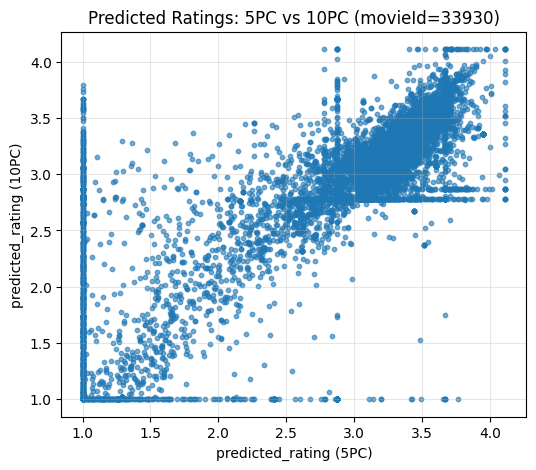

Saved: c:\Users\Youssef Reda\Desktop\Semester 9\IRS\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\plots\part_2\scatter_5PC_vs_10PC_movieId_33930.png


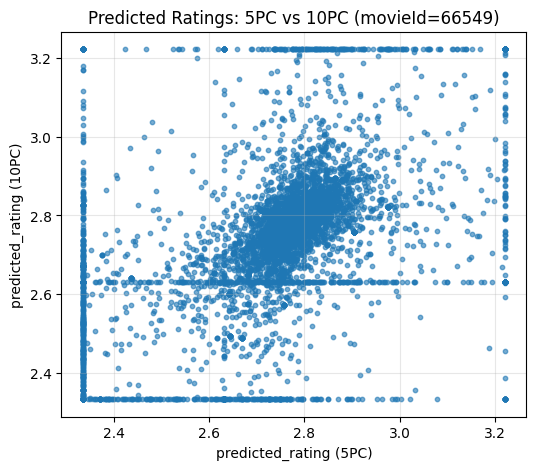

Saved: c:\Users\Youssef Reda\Desktop\Semester 9\IRS\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\plots\part_2\scatter_5PC_vs_10PC_movieId_66549.png


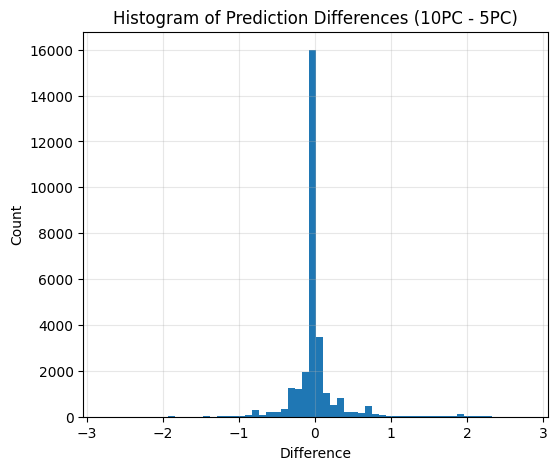

Saved: c:\Users\Youssef Reda\Desktop\Semester 9\IRS\AIE425_FinalProject_Group[X]\SECTION1_DimensionalityReduction\results\plots\part_2\hist_diff_10PC_minus_5PC.png


In [ ]:

# =========================
# Paths
# =========================
nb_dir = Path.cwd()
project_dir = nb_dir.parent

plots_dir = project_dir / "results" / "plots" / "Part_2"
plots_dir.mkdir(parents=True, exist_ok=True)

p5_pred_path  = project_dir / "results" / "tables" / "part_2" / "predicted_ratings_top5PCs.csv"
p10_pred_path = project_dir / "results" / "tables" / "part_2" / "predicted_ratings_top10PCs.csv"

pred5  = pd.read_csv(p5_pred_path)
pred10 = pd.read_csv(p10_pred_path)

# Merge
m = pred5.merge(pred10, on=["userId", "movieId"], how="inner", suffixes=("_5PC", "_10PC"))
m["diff_10_minus_5"] = m["predicted_rating_10PC"] - m["predicted_rating_5PC"]

# Correlation
def corr_for_item(df_item):
    a = df_item["predicted_rating_5PC"].values
    b = df_item["predicted_rating_10PC"].values
    return np.corrcoef(a, b)[0, 1] if len(a) > 1 else np.nan

corrs = m.groupby("movieId").apply(corr_for_item).rename("corr(5PC,10PC)")
print("\n=== CORRELATION BETWEEN 5PC AND 10PC PREDICTIONS (per target) ===")
display(corrs)

# =========================
# Scatter plots (SAVE then SHOW)
# =========================
for item_id, g in m.groupby("movieId"):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(g["predicted_rating_5PC"], g["predicted_rating_10PC"], s=10, alpha=0.6)
    ax.set_title(f"Predicted Ratings: 5PC vs 10PC (movieId={item_id})")
    ax.set_xlabel("predicted_rating (5PC)")
    ax.set_ylabel("predicted_rating (10PC)")
    ax.grid(alpha=0.3)

    out_file = plots_dir / f"scatter_5PC_vs_10PC_movieId_{item_id}.png"
    fig.savefig(out_file, dpi=200, bbox_inches="tight")  
    plt.show()                                           
    plt.close(fig)

    print("Saved:", out_file)

# =========================
# Histogram (SAVE then SHOW)
# =========================
fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(m["diff_10_minus_5"], bins=60)
ax.set_title("Histogram of Prediction Differences (10PC - 5PC)")
ax.set_xlabel("Difference")
ax.set_ylabel("Count")
ax.grid(alpha=0.3)

out_file = plots_dir / "hist_diff_10PC_minus_5PC.png"
fig.savefig(out_file, dpi=200, bbox_inches="tight")  
plt.show()                                           
plt.close(fig)

print("Saved:", out_file)


In [ ]:


# eigvals_sorted must already exist and be sorted descending
eigvals = np.array(eigvals, dtype=float)

# Sanity check: covariance eigenvalues should be non-negative
eigvals = eigvals[eigvals > 0]

total_variance = eigvals.sum()

explained_var_ratio = eigvals / total_variance
cumulative_var = np.cumsum(explained_var_ratio)

# ---- Display table for first 10 PCs ----
var_table = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(10)],
    "Explained Variance (%)": explained_var_ratio[:10] * 100,
    "Cumulative Variance (%)": cumulative_var[:10] * 100
})

print("=== CUMULATIVE EXPLAINED VARIANCE (TEXT ONLY) ===")
display(var_table)

# ---- Explicit comparison ----
print(f"Top 5 PCs cumulative variance:  {cumulative_var[4] * 100:.2f}%")
print(f"Top 10 PCs cumulative variance: {cumulative_var[9] * 100:.2f}%")
print(f"Gain from 5 → 10 PCs:           {(cumulative_var[9] - cumulative_var[4]) * 100:.2f}%")


=== CUMULATIVE EXPLAINED VARIANCE (TEXT ONLY) ===


,PC,Explained Variance (%),Cumulative Variance (%)
0,PC1,3.669630,3.669630
1,PC2,2.213261,5.882891
2,PC3,1.829813,7.712703
3,PC4,1.673802,9.386505
4,PC5,1.542720,10.929226
5,PC6,1.384397,12.313623
6,PC7,1.339074,13.652696
7,PC8,1.277655,14.930352
8,PC9,1.202692,16.133044
9,PC10,1.106705,17.239749


Top 5 PCs cumulative variance:  10.93%
Top 10 PCs cumulative variance: 17.24%
Gain from 5 → 10 PCs:           6.31%


8- Compare the results of point 9 in part 1 with results of point 4. comment your answer.

9- Compare the results of point 11 in part 1 with results of point 6. comment your answer.

Computational efficency

In [ ]:


# ---------------- Helpers ----------------
def mb(nbytes): 
    return nbytes / (1024**2)

def cosine_sim_matrix(X: np.ndarray) -> np.ndarray:
    """Manual cosine similarity: (X/||X||) @ (X/||X||)^T"""
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    Xn = X / np.maximum(norms, 1e-12)
    return Xn @ Xn.T

def predict_targets_from_sim(sim, user_ids, df_ratings, centered_matrix, item_means, targets=(33930,66549), k=5):
    """
    Predict missing ratings for target items using:
      r_hat = mu_i + (sum(w * deviation) / sum(w))
    where peers are TOP-k users with positive cosine similarity among users who rated the target item.
    Returns a DataFrame of predictions (userId, movieId, predicted_rating).
    """
    user_ids = np.array(user_ids, dtype=int)
    user_index = {uid: idx for idx, uid in enumerate(user_ids)}

    rated_pairs = set(zip(df_ratings["userId"].astype(int), df_ratings["movieId"].astype(int)))

    rows = []
    for target_item_id in targets:
        target_item_id = int(target_item_id)
        if target_item_id not in item_means:
            continue

        rated_users = df_ratings.loc[df_ratings["movieId"] == target_item_id, "userId"].astype(int).unique()
        rated_users = [u for u in rated_users if u in user_index]  # keep only users in embedding space

        # users missing this item
        missing_users = [u for u in user_ids if (int(u), target_item_id) not in rated_pairs]

        for u in missing_users:
            ui = user_index[int(u)]

            # fallback if nobody rated it in our reduced space
            if len(rated_users) == 0:
                rows.append((int(u), target_item_id, float(item_means[target_item_id])))
                continue

            # similarities to rated users
            sims = np.array([sim[ui, user_index[ru]] for ru in rated_users], dtype=float)

            # positive sims only
            mask = sims > 0
            if not mask.any():
                rows.append((int(u), target_item_id, float(item_means[target_item_id])))
                continue

            sims_pos = sims[mask]
            peers_pos = np.array(rated_users, dtype=int)[mask]

            # top-k selection (no full sort)
            if len(sims_pos) > k:
                top_idx = np.argpartition(-sims_pos, k-1)[:k]
                weights = sims_pos[top_idx]
                peers = peers_pos[top_idx]
            else:
                weights = sims_pos
                peers = peers_pos

            # deviations for peers on this item
            devs = centered_matrix.loc[peers, target_item_id].dropna()
            if len(devs) == 0:
                rows.append((int(u), target_item_id, float(item_means[target_item_id])))
                continue

            # align weights to devs index
            w_map = {int(p): w for p, w in zip(peers, weights)}
            w = np.array([w_map[int(p)] for p in devs.index], dtype=float)

            pred_dev = float((w * devs.values).sum() / w.sum())
            r_hat = float(item_means[target_item_id] + pred_dev)

            rows.append((int(u), target_item_id, r_hat))

    return pd.DataFrame(rows, columns=["userId", "movieId", "predicted_rating"])

# ---------------- Paths (same structure as your notebook) ----------------
nb_dir = Path.cwd()                              # SECTION1_DimensionalityReduction/code
project_dir = nb_dir.parent                      # SECTION1_DimensionalityReduction
data_dir = project_dir / "data"
stats_dir = project_dir / "results" / "tables" / "stats_analysis"
part2_dir = project_dir / "results" / "tables" / "part_2"

# ---------------- Load data for prediction ----------------
df = pd.read_csv(data_dir / "ratings.csv")  # raw ratings for "who rated what"

mc = pd.read_csv(part2_dir / "item_mean_centered.csv")  # userId, movieId, mean_centered_rating, timestamp
centered_matrix = mc.pivot(index="userId", columns="movieId", values="mean_centered_rating")

item_means_df = pd.read_csv(stats_dir / "item_avg_ratings.csv")  # movieId, avg_rating
item_means = item_means_df.set_index("movieId")["avg_rating"].to_dict()

# ---------------- Covariance matrix for PCA decomposition ----------------
# Your notebook uses either `Sigma` (np.array) or `cov` (list of lists).
if "Sigma" in globals():
    Sigma_local = np.array(Sigma, dtype=float)
elif "cov" in globals():
    Sigma_local = np.array(cov, dtype=float)
else:
    raise NameError("I couldn't find `Sigma` or `cov` in your notebook. Run the covariance construction cell first.")

I = Sigma_local.shape[0]  # items
R = len(df)               # ratings

print("=== DATA SIZES ===")
print(f"Items (I): {I}")
print(f"Ratings (R): {R}")

# ---------------- Theoretical complexity (Big-O) ----------------
print("\n=== THEORETICAL TIME COMPLEXITY (HIGH LEVEL) ===")
print("Covariance build (co-rated):  O( sum_u d_u^2 )  (sparse)  ~ worst O(U * I^2)")
print("Eigen-decomposition (I x I):  O(I^3)")
print("User projection:              O(R * K)")
print("User-user similarity:         O(U^2 * K)")
print("Prediction for targets:       ~ O(Σ_i N_i * M_i)  (plus neighbor selection)")

# ---------------- Runtime: Matrix decomposition ----------------
t0 = time.perf_counter()
eigvals, eigvecs = np.linalg.eigh(Sigma_local)
t1 = time.perf_counter()
decomp_time = t1 - t0

print("\n=== ACTUAL RUNTIME ===")
print(f"[Matrix Decomposition] np.linalg.eigh on ({I}x{I}): {decomp_time:.4f} sec")

# Memory for decomposition artifacts
print("\n=== MEMORY REQUIREMENTS (MB) ===")
print(f"Covariance Sigma:   {Sigma_local.shape} -> {mb(Sigma_local.nbytes):.2f} MB")
print(f"Eigenvectors:       {eigvecs.shape} -> {mb(eigvecs.nbytes):.2f} MB")
print(f"Eigenvalues:        {eigvals.shape} -> {mb(eigvals.nbytes):.4f} MB")

# Sort descending like your notebook
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

# ---------------- Compare K=5 vs K=10 (user embeddings + sim + prediction) ----------------
def run_profile_for_K(K: int, emb_csv: Path, k_neighbors=5, targets=(33930,66549)):
    user_emb = pd.read_csv(emb_csv).set_index("userId")
    U = user_emb.shape[0]

    # Similarity runtime
    X = user_emb.values.astype(float)
    t0 = time.perf_counter()
    sim = cosine_sim_matrix(X)
    t1 = time.perf_counter()
    sim_time = t1 - t0

    # Prediction runtime
    t0 = time.perf_counter()
    pred_df = predict_targets_from_sim(
        sim=sim,
        user_ids=user_emb.index.values,
        df_ratings=df,
        centered_matrix=centered_matrix,
        item_means=item_means,
        targets=targets,
        k=k_neighbors
    )
    t1 = time.perf_counter()
    pred_time = t1 - t0

    # Memory
    sim_mem = mb(sim.nbytes)
    emb_mem = mb(X.nbytes)

    print(f"\n--- K={K} (Reduced user space) ---")
    print(f"Users (U): {U}")
    print(f"[Similarity] Runtime: {sim_time:.4f} sec | Memory: {sim_mem:.2f} MB (U x U)")
    print(f"[Prediction] Runtime (targets={list(targets)}): {pred_time:.4f} sec | Rows predicted: {len(pred_df)}")
    print(f"[Embeddings] Memory: {emb_mem:.2f} MB (U x K)")
    return pred_df, sim_time, pred_time, sim_mem

# K=5
pred5, sim5_t, pred5_t, sim5_mem = run_profile_for_K(
    K=5,
    emb_csv=part2_dir / "user_embeddings_pca5.csv",
    k_neighbors=5,
    targets=(33930,66549)
)

# K=10
pred10, sim10_t, pred10_t, sim10_mem = run_profile_for_K(
    K=10,
    emb_csv=part2_dir / "user_embeddings_pca10.csv",
    k_neighbors=5,
    targets=(33930,66549)
)

# ---------------- Explained variance numbers (Top 10, Top 5 cumulative) ----------------
# (Numbers only, no plot)
eigvals_pos = eigvals[eigvals > 0]
evr = eigvals_pos / eigvals_pos.sum()
cum = np.cumsum(evr)

print("\n=== CUMULATIVE EXPLAINED VARIANCE (NO PLOT) ===")
for i in range(10):
    print(f"PC{i+1}: {evr[i]*100:.4f}% | cumulative: {cum[i]*100:.4f}%")
print(f"Top 5 PCs cumulative:  {cum[4]*100:.4f}%")
print(f"Top 10 PCs cumulative: {cum[9]*100:.4f}%")
print(f"Gain 5 -> 10 PCs:      {(cum[9]-cum[4])*100:.4f}%")


=== DATA SIZES ===
Items (I): 900
Ratings (R): 109342

=== THEORETICAL TIME COMPLEXITY (HIGH LEVEL) ===
Covariance build (co-rated):  O( sum_u d_u^2 )  (sparse)  ~ worst O(U * I^2)
Eigen-decomposition (I x I):  O(I^3)
User projection:              O(R * K)
User-user similarity:         O(U^2 * K)
Prediction for targets:       ~ O(Σ_i N_i * M_i)  (plus neighbor selection)

=== ACTUAL RUNTIME ===
[Matrix Decomposition] np.linalg.eigh on (900x900): 0.3083 sec

=== MEMORY REQUIREMENTS (MB) ===
Covariance Sigma:   (900, 900) -> 6.18 MB
Eigenvectors:       (900, 900) -> 6.18 MB
Eigenvalues:        (900,) -> 0.0069 MB

--- K=5 (Reduced user space) ---
Users (U): 14638
[Similarity] Runtime: 2.1959 sec | Memory: 1634.76 MB (U x U)
[Prediction] Runtime (targets=[33930, 66549]): 15.2700 sec | Rows predicted: 29268
[Embeddings] Memory: 0.56 MB (U x K)

--- K=10 (Reduced user space) ---
Users (U): 14638
[Similarity] Runtime: 1.9379 sec | Memory: 1634.76 MB (U x U)
[Prediction] Runtime (targets=[339